In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualisation
import tensorflow as tf


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['year_prediction.csv']


In [2]:
data = pd.read_csv("../input/year_prediction.csv")
data = data.rename(index=str, columns={"label":"year"})

We plot a histogram to understand how evenly spread the data is by viewing number of songs we have for a given year.

Text(0, 0.5, 'Number of songs')

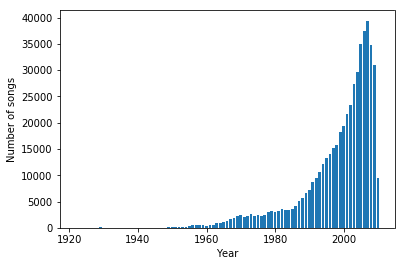

In [3]:
nsongs = {}
for y in range(1922,2012):
    nsongs[y] = len(data[data.year==y])
yrs = range(1922,2011)
values = [nsongs[y] for y in yrs]
plt.bar(yrs, values, align='center')
plt.xlabel("Year")
plt.ylabel("Number of songs")

In [4]:
# separate input attributes and output into different dataframes
X = data.iloc[:,1:]
Y = data.iloc[:,0]

# Train set
X_train = X.iloc[0:463715,:]
y_train = Y.iloc[0:463715]

# Validation set
X_test = X.iloc[463715:,:]
y_test = Y.iloc[463715:]


Each of the features takes a wide range of different values and distributions.

We apply MinMax scaling to our data.

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the train set and the test set.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled,columns=X_train.columns)

In [6]:
X_train.describe()

,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,TimbreAvg10,TimbreAvg11,TimbreAvg12,TimbreCovariance1,TimbreCovariance2,TimbreCovariance3,TimbreCovariance4,TimbreCovariance5,TimbreCovariance6,TimbreCovariance7,TimbreCovariance8,TimbreCovariance9,TimbreCovariance10,TimbreCovariance11,TimbreCovariance12,TimbreCovariance13,TimbreCovariance14,TimbreCovariance15,TimbreCovariance16,TimbreCovariance17,TimbreCovariance18,TimbreCovariance19,TimbreCovariance20,TimbreCovariance21,TimbreCovariance22,TimbreCovariance23,TimbreCovariance24,TimbreCovariance25,TimbreCovariance26,TimbreCovariance27,TimbreCovariance28,...,TimbreCovariance39,TimbreCovariance40,TimbreCovariance41,TimbreCovariance42,TimbreCovariance43,TimbreCovariance44,TimbreCovariance45,TimbreCovariance46,TimbreCovariance47,TimbreCovariance48,TimbreCovariance49,TimbreCovariance50,TimbreCovariance51,TimbreCovariance52,TimbreCovariance53,TimbreCovariance54,TimbreCovariance55,TimbreCovariance56,TimbreCovariance57,TimbreCovariance58,TimbreCovariance59,TimbreCovariance60,TimbreCovariance61,TimbreCovariance62,TimbreCovariance63,TimbreCovariance64,TimbreCovariance65,TimbreCovariance66,TimbreCovariance67,TimbreCovariance68,TimbreCovariance69,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78
count,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,...,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000
mean,0.691393,0.469181,0.496357,0.350035,0.395117,0.358260,0.515310,0.397887,0.477290,0.426607,0.691819,0.530809,0.061015,0.036932,0.052829,0.046941,0.045245,0.051828,0.054789,0.053319,0.040334,0.083562,0.041914,0.029258,0.588071,0.354463,0.451344,0.555480,0.508205,0.473871,0.676466,0.443812,0.369822,0.404615,0.353309,0.424043,0.371572,0.562552,0.605844,0.486739,...,0.615812,0.421879,0.573337,0.431647,0.744069,0.400336,0.372550,0.266772,0.362311,0.301800,0.512831,0.537379,0.417522,0.477130,0.719306,0.530612,0.369416,0.353011,0.269319,0.554657,0.639893,0.595036,0.795590,0.521606,0.512374,0.488463,0.494068,0.376795,0.631798,0.563245,0.354631,0.487984,0.368845,0.657332,0.568014,0.466481,0.600205,0.343815,0.503517,0.347715
std,0.100947,0.071570,0.056527,0.036814,0.051474,0.063671,0.040431,0.044802,0.038783,0.063964,0.043463,0.045744,0.040440,0.026595,0.034290,0.034337,0.023954,0.034274,0.029750,0.032271,0.022275,0.044558,0.027650,0.015673,0.024969,0.018895,0.020548,0.028204,0.024609,0.020223,0.017601,0.020666,0.016301,0.013634,0.015131,0.025654,0.018390,0.024946,0.016436,0.012650,...,0.025309,0.017857,0.012536,0.016366,0.025507,0.023793,0.022147,0.015102,0.020012,0.017587,0.015973,0.023356,0.026971,0.014372,0.021669,0.017463,0.030666,0.015855,0.014724,0.021925,0.022821,0.019606,0.015579,0.018304,0.024269,0.018045,0.013502,0.026496,0.015304,0.014604,0.025093,0.019768,0.024255,0.019886,0.026819,0.016738,0.024350,0.019045,0.012446

90 features is lot of features and so we attempt dimensionality reduction by implementing PCA.

# PCA

First we normalise our data using scikits StandardScalar.
This is a necessary step for pca:
> Principle Component Analysis (PCA) as being a prime example of when normalization is important. In PCA we are interested in the components that maximize the variance. If one component (e.g. human height) varies less than another (e.g. weight) because of their respective scales (meters vs. kilos), PCA might determine that the direction of maximal variance more closely corresponds with the ‘weight’ axis, if those features are not scaled. As a change in height of one meter can be considered much more important than the change in weight of one kilogram, this is clearly incorrect.
(https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py)

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the train set and the test set.
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [8]:
X_train_std = pd.DataFrame(X_train_std,columns=X_train.columns)
X_train_std.describe()

,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,TimbreAvg10,TimbreAvg11,TimbreAvg12,TimbreCovariance1,TimbreCovariance2,TimbreCovariance3,TimbreCovariance4,TimbreCovariance5,TimbreCovariance6,TimbreCovariance7,TimbreCovariance8,TimbreCovariance9,TimbreCovariance10,TimbreCovariance11,TimbreCovariance12,TimbreCovariance13,TimbreCovariance14,TimbreCovariance15,TimbreCovariance16,TimbreCovariance17,TimbreCovariance18,TimbreCovariance19,TimbreCovariance20,TimbreCovariance21,TimbreCovariance22,TimbreCovariance23,TimbreCovariance24,TimbreCovariance25,TimbreCovariance26,TimbreCovariance27,TimbreCovariance28,...,TimbreCovariance39,TimbreCovariance40,TimbreCovariance41,TimbreCovariance42,TimbreCovariance43,TimbreCovariance44,TimbreCovariance45,TimbreCovariance46,TimbreCovariance47,TimbreCovariance48,TimbreCovariance49,TimbreCovariance50,TimbreCovariance51,TimbreCovariance52,TimbreCovariance53,TimbreCovariance54,TimbreCovariance55,TimbreCovariance56,TimbreCovariance57,TimbreCovariance58,TimbreCovariance59,TimbreCovariance60,TimbreCovariance61,TimbreCovariance62,TimbreCovariance63,TimbreCovariance64,TimbreCovariance65,TimbreCovariance66,TimbreCovariance67,TimbreCovariance68,TimbreCovariance69,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78
count,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,...,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05,4.637150e+05
mean,7.860182e-16,-2.091763e-15,1.355798e-16,-1.357427e-15,-8.698030e-16,1.346587e-15,-5.625596e-16,4.602650e-16,-3.256487e-16,1.911129e-15,4.018197e-15,-2.502608e-15,-6.190568e-17,-1.069821e-17,-3.529729e-16,-9.763661e-17,-2.724692e-16,2.504086e-16,8.627746e-16,4.121119e-16,-6.631095e-16,3.394529e-16,-7.586569e-16,-8.156104e-17,-8.968334e-15,-2.391046e-15,6.454967e-15,-2.494976e-15,4.325894e-15,2.140151e-17,5.876518e-15,-1.396214e-15,3.546603e-15,1.237439e-14,1.326574e-14,-1.499921e-15,-2.790937e-15,-4.764826e-16,8.122309e-15,5.200963e-15,...,-7.736401e-16,8.136067e-15,2.407077e-14,5.731586e-15,1.305549e-15,5.385272e-16,1.614794e-15,-3.452024e-15,-1.443823e-15,1.322732e-17,2.803837e-15,8.785695e-15,-9.397954e-16,-6.418378e-15,2.609099e-15,-8.714935e-16,2.895461e-15,-1.027189e-14,3.537959e-16,3.607981e-15,-5.811512e-15,3.722570e-15,-4.277726e-15,5.148444e-15,7.730112e-16,-2.349867e-15,-7.733918e-16,2.570563e-15,7.668392e-15,1.063528e-14,1.832125e-16,8.840391e-16,-4.720778e-15,-1.128972e-15,-4.590983e-15,-8.157310e-15,-2.556776e-15,-1.843250e-15,-7.529481e-15,4.832588e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.0000

Our values are normalised and so we now actually apply PCA
(https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60)

In [9]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.90)

# We fit to only our training set
pca.fit(X_train_std)
# Print number of components generated
pca.n_components_

55

PCA(.90) means that scikit-learn choose the minimum number of principal components such that 90% of the variance is retained.

In this case, 90% of the variance amounts to 55 principal components.

In [10]:
X_train_proc = pca.transform(X_train_std)
X_test_proc = pca.transform(X_test_std)

In [11]:
y_train_proc = y_train - min(y_train)
y_test_proc = y_test - min(y_test)
# y_train_proc

# Neural Network

In [12]:
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, Lambda, Dropout
# from tensorflow.python.keras.initializers import Initializer
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [13]:
y_train_hot = to_categorical(y_train_proc, 90)
y_test_hot = to_categorical(y_test_proc, 90)

In [14]:
print(X_train_proc.shape)
print(y_test_hot.shape)

(463715, 55)
(51630, 90)


In [15]:
def plot(history):
    epochs = range(1, len(history.history['loss']) + 1)
    plt.plot(epochs, history.history['mean_absolute_error'], label='train');
    plt.plot(epochs, history.history['val_mean_absolute_error'], label='val');
    plt.xlabel('epoch');
    plt.ylabel('mae');
    plt.legend();
    plt.show();

In [16]:
model1 = Sequential()
model1.add(Dense(55, input_shape=(55,)))
model1.add(Dense(110))
model1.add(Dense(90, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

In [18]:
model1.compile(optimizer='adam'
             , loss='categorical_crossentropy'
             , metrics=['accuracy'])

In [19]:
fit1 = model1.fit(x=X_train_proc, y=y_train_hot
          , epochs=5
          , batch_size=64
          , validation_data=(X_test_proc, y_test_hot)
          , callbacks=[learning_rate_reduction])

Train on 463715 samples, validate on 51630 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
463715/463715 [==============================] - 22s 47us/sample - loss: 3.3497 - acc: 0.0754 - val_loss: 3.8857 - val_acc: 0.0060
Epoch 2/5
463715/463715 [==============================] - 23s 50us/sample - loss: 3.3127 - acc: 0.0766 - val_loss: 3.8507 - val_acc: 0.0104
Epoch 3/5
463715/463715 [==============================] - 23s 50us/sample - loss: 3.3094 - acc: 0.0775 - val_loss: 3.8464 - val_acc: 0.0038
Epoch 4/5
463715/463715 [==============================] - 21s 46us/sample - loss: 3.3078 - acc: 0.0777 - val_loss: 3.8373 - val_acc: 0.0063
Epoch 5/5
463715/463715 [==============================] - 21s 46us/sample - loss: 3.3064 - acc: 0.0775 - val_loss: 3.8320 - val_acc: 0.0077


In [20]:
# plot(fit1)

In [21]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 55)                3080      
_________________________________________________________________
dense_1 (Dense)              (None, 110)               6160      
_________________________________________________________________
dense_2 (Dense)              (None, 90)                9990      
Total params: 19,230
Trainable params: 19,230
Non-trainable params: 0
_________________________________________________________________


In [22]:
preds = model1.predict_classes(X_test_proc)

In [23]:
print(np.array(y_test_proc))
print(preds)
np.mean(np.absolute((preds-np.array(y_test_proc))))

[80 76 78 ... 79 79 78]
[83 85 85 ... 85 85 85]


12.18074762734844

In [24]:
model2 = Sequential()
model2.add(Dense(55, input_shape=(55,), activation='relu'))
model2.add(Dense(1))

In [25]:
learning_rate_reduction1 = ReduceLROnPlateau(monitor='mean_absolute_error', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

In [26]:
model2.compile(optimizer='adam'
             , loss='mse'
             , metrics=['mae'])

Instructions for updating:
Use tf.cast instead.


In [27]:
fit2 = model2.fit(x=X_train_proc, y=y_train_proc
          , epochs=10
          , batch_size=64
          , validation_data=(X_test_proc, y_test_proc)
          , callbacks=[learning_rate_reduction1])

Train on 463715 samples, validate on 51630 samples
Epoch 1/10
463715/463715 [==============================] - 19s 40us/sample - loss: 454.0315 - mean_absolute_error: 13.8813 - val_loss: 126.2524 - val_mean_absolute_error: 7.8502
Epoch 2/10
463715/463715 [==============================] - 17s 37us/sample - loss: 96.3439 - mean_absolute_error: 7.1983 - val_loss: 119.6077 - val_mean_absolute_error: 7.5977
Epoch 3/10
463715/463715 [==============================] - 17s 37us/sample - loss: 92.9060 - mean_absolute_error: 7.0213 - val_loss: 121.2777 - val_mean_absolute_error: 7.7042
Epoch 4/10
463715/463715 [==============================] - 17s 37us/sample - loss: 91.5295 - mean_absolute_error: 6.9511 - val_loss: 116.8438 - val_mean_absolute_error: 7.4562
Epoch 5/10
463715/463715 [==============================] - 18s 39us/sample - loss: 90.6753 - mean_absolute_error: 6.9032 - val_loss: 118.6354 - val_mean_absolute_error: 7.6665
Epoch 6/10
463715/463715 [==============================] - 17

In [28]:
preds_model_rms = model2.predict(X_test_proc)
np.mean(np.absolute(preds_model_rms.T-np.array(y_test_proc)))

7.533661957422523

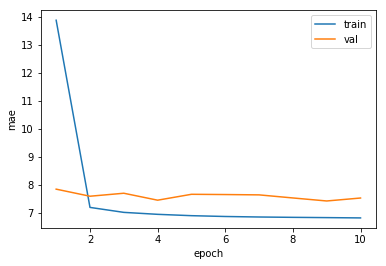

In [29]:
plot(fit2)

In [30]:
# from sklearn.metrics import mean_squared_error, r2_score
# mean_squared_error(predictions_linearRegr, np.array(y_test_proc))
es = EarlyStopping(monitor='val_mean_absolute_error', patience=2, restore_best_weights=True)

In [31]:
model3 = Sequential()
model3.add(Dense(55, input_shape=(55,), activation='relu'))
model3.add(Dense(110, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1))

model3.compile(optimizer='adam'
             , loss='mse'
             , metrics=['mae'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [32]:
fit3 = model3.fit(x=X_train_proc, y=y_train_proc
          , epochs=10
          , batch_size=64
          , validation_data=(X_test_proc, y_test_proc)
          , callbacks=[learning_rate_reduction1, es])

Train on 463715 samples, validate on 51630 samples
Epoch 1/10
463715/463715 [==============================] - 20s 44us/sample - loss: 220.8219 - mean_absolute_error: 10.4302 - val_loss: 119.6071 - val_mean_absolute_error: 7.7226
Epoch 2/10
463715/463715 [==============================] - 20s 44us/sample - loss: 117.5109 - mean_absolute_error: 8.2226 - val_loss: 122.8387 - val_mean_absolute_error: 7.8060
Epoch 3/10
463715/463715 [==============================] - 20s 43us/sample - loss: 114.2269 - mean_absolute_error: 8.0849 - val_loss: 105.3596 - val_mean_absolute_error: 7.0479
Epoch 4/10
463715/463715 [==============================] - 23s 50us/sample - loss: 111.7011 - mean_absolute_error: 7.9776 - val_loss: 117.5443 - val_mean_absolute_error: 7.5872
Epoch 5/10
463715/463715 [==============================] - 20s 43us/sample - loss: 110.0584 - mean_absolute_error: 7.9063 - val_loss: 111.5645 - val_mean_absolute_error: 7.4130


In [33]:
preds_model_rms = model3.predict(X_test_proc)
np.mean(np.absolute(preds_model_rms.T-np.array(y_test_proc)))

7.047857569004246

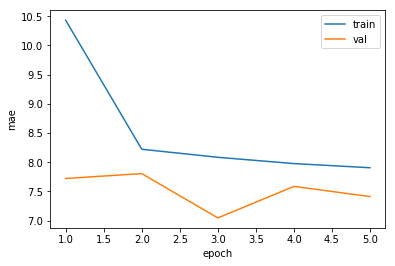

In [34]:
plot(fit3)

batch size = 64

In [35]:
model3.compile(optimizer='adam'
             , loss='mse'
             , metrics=['mae'])
fit3 = model3.fit(x=X_train_proc, y=y_train_proc
          , epochs=10
          , batch_size=128
          , validation_data=(X_test_proc, y_test_proc)
          , callbacks=[learning_rate_reduction1, es])

Train on 463715 samples, validate on 51630 samples
Epoch 1/10
463715/463715 [==============================] - 11s 23us/sample - loss: 111.0970 - mean_absolute_error: 7.9487 - val_loss: 109.0630 - val_mean_absolute_error: 7.2164
Epoch 2/10
463715/463715 [==============================] - 10s 22us/sample - loss: 110.0095 - mean_absolute_error: 7.9035 - val_loss: 111.0600 - val_mean_absolute_error: 7.3114
Epoch 3/10
463715/463715 [==============================] - 10s 22us/sample - loss: 108.6083 - mean_absolute_error: 7.8469 - val_loss: 112.4737 - val_mean_absolute_error: 7.3348


In [36]:
preds_model_rms = model3.predict(X_test_proc)
np.mean(np.absolute(preds_model_rms.T-np.array(y_test_proc)))

7.216405226910458

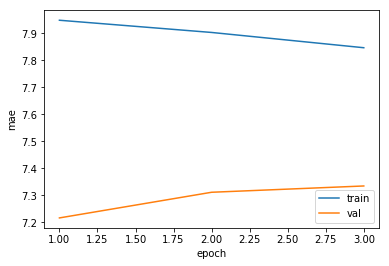

In [37]:
plot(fit3)

batch size = 128

In [38]:
from keras.optimizers import RMSprop
# adam = optimizers.Adam()

Using TensorFlow backend.


In [39]:
model3.compile(optimizer='RMSprop'
             , loss='mse'
             , metrics=['mae'])
fit4 = model3.fit(x=X_train_proc, y=y_train_proc
          , epochs=10
          , batch_size=64
          , validation_data=(X_test_proc, y_test_proc)
          , callbacks=[learning_rate_reduction1, es])

Train on 463715 samples, validate on 51630 samples
Epoch 1/10
463715/463715 [==============================] - 20s 43us/sample - loss: 110.6858 - mean_absolute_error: 7.9279 - val_loss: 133.4714 - val_mean_absolute_error: 8.3044
Epoch 2/10
463715/463715 [==============================] - 18s 39us/sample - loss: 109.3629 - mean_absolute_error: 7.8753 - val_loss: 116.5361 - val_mean_absolute_error: 7.5751
Epoch 3/10
463715/463715 [==============================] - 18s 39us/sample - loss: 108.0603 - mean_absolute_error: 7.8145 - val_loss: 99.5788 - val_mean_absolute_error: 6.8666
Epoch 4/10
463715/463715 [==============================] - 18s 39us/sample - loss: 106.9977 - mean_absolute_error: 7.7635 - val_loss: 114.6966 - val_mean_absolute_error: 7.4764
Epoch 5/10
463715/463715 [==============================] - 20s 42us/sample - loss: 105.5895 - mean_absolute_error: 7.7047 - val_loss: 122.0308 - val_mean_absolute_error: 7.7521


In [40]:
preds_model_rms = model3.predict(X_test_proc)
np.mean(np.absolute(preds_model_rms.T-np.array(y_test_proc)))

6.866590757072607

In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.round_(np.array(preds_model_rms), decimals=-1), np.round_(np.array(y_test_proc), decimals=-1))

,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020
1920,0,0,0,0,0,0,0,0,0,0,0
1930,0,0,0,0,0,0,0,0,0,0,0
1940,0,0,0,0,0,0,0,0,0,0,0
1950,0,0,0,0,0,0,0,0,0,0,0
1960,0,0,0,0,0,0,0,0,0,0,0
1970,3,1,0,1,41,25,17,30,27,0,0
1980,22,33,21,120,532,508,848,928,783,0,0
1990,1,12,50,160,1021,1433,3923,6059,6644,0,0
2000,0,0,0,21,196,410,1204,7187,19303,0,0
2010,0,0,0,0,0,1,2,8,53,0,0


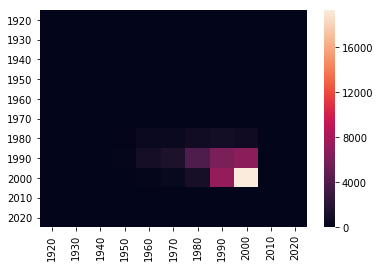

In [42]:
import seaborn as sns
ind = list(range(1920,2030,10))
df_heat = pd.DataFrame(cm, index=ind, columns=ind)
len(ind)
# lab = pd.unique(df_heat[0])
sns.heatmap(df_heat)
df_heat
# df_plot.transpose().corr()
# cm.shape